In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [119]:
params = []
for path in sorted(glob.glob("../../../../logs/lions-maxtwo**-2019-06-19*/**/rep00/", recursive=True) 
                   + glob.glob("../../../../logs/lions-maxtwo*-2019-06-15*/**/rep00/", recursive=True)
                  + glob.glob("../../../../logs/lions-maxtwo*-2019-06-14*/**/rep00/", recursive=True)
                   + glob.glob("../../../../logs/lions-maxtwo*-2019-06-13*/**/rep00/", recursive=True)
                  + glob.glob("../../../../logs/lions-maxtwo**-2019-06-20*/**/rep00/", recursive=True)):
    print(path)
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    print('*-*-*')
    params.append((path, readparams(glob.glob(path + 'properties*')[0]), logall.query('nbOnOpp == 2')['curCoopNoCoef'].mean()))

diffkeys = []
for key in params[0][1].keys():
    if any(params[i][1][key] != params[0][1][key] for i in range(1, len(params))):
        diffkeys.append(key)

../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-1000-2019-06-14-1742/lion_big/o120/mt_true/run_01/rep00/
*-*-*
../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-1000-2019-06-14-1742/lion_big/o120/mt_true/run_02/rep00/
*-*-*
../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-500-2019-06-15-0459/lion_big/o120/mt_true/run_01/rep00/
*-*-*
../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b10-nocost-decay-500-2019-06-15-0459/lion_big/o120/mt_true/run_02/rep00/
*-*-*
../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b3-nocost-decay-1000-2019-06-14-1744/lion_big/o120/mt_true/run_01/rep00/
*-*-*
../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b3-nocost-decay-1000-2019-06-14-1744/lion_big/o120/mt_true/run_02/rep00/
*-*-*
../../../../logs/lions-maxtwo-pop100-lowmut-lotofreps-fake_true-0.1-b3-nocost-decay-500-2019-06-14-1744/lion_big/o12

In [132]:
excluded = ['gSeed', 'gLogFilename', 'path']
processed = []
for elem in params:
    param = elem[1]
    ess = param['meanA'] / 2
    so = param['meanA'] + param['b'] / 2
    outdict = {'coop': (elem[2] - ess) / (so - ess) , 'truecoop': elem[2]}
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem[1][key]
    processed.append(outdict)
df = pd.DataFrame(processed)
normalized_df=(df-df.mean())/df.std()

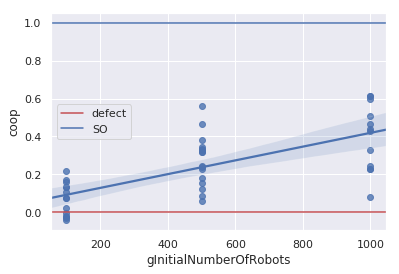

In [141]:
sns.regplot(x='gInitialNumberOfRobots', y='coop', data=df)
plt.axhline(0, label='defect', c='r')
plt.axhline(1, label='SO', c='b')
plt.legend()

In [143]:
import statsmodels.formula.api as sm

In [144]:
normalized_df['nbRobots'] = normalized_df['gInitialNumberOfRobots']
normalized_df['tau'] = normalized_df['oppDecay']
normalized_df['coopVariability'] = normalized_df['fakeCoef']

In [145]:
result = sm.ols(formula="coop ~ nbRobots + b + tau + coopVariability", data=normalized_df).fit()

In [146]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coop   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     9.377
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           2.45e-05
Time:                        15:33:34   Log-Likelihood:                -44.390
No. Observations:                  42   AIC:                             98.78
Df Residuals:                      37   BIC:                             107.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.718e-16      0.114   4.12e-15      1.000      -0.232       0.232
nbRobots            0.7255      0.120      6.024      0.000       0.481       0.970
b                   0.1317      0.120      1.093      0.281      -0.112       0.376
tau                 0.0078      0.116      0.067      0.947      -0.228       0.243
coopVariability    -0.0841      0.116     -0.725      0.473      -0.319       0.151
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.037
Skew:                           0.032   Prob(JB):                        0.982
Kurtosis:                       2.869   Cond. No.                         1.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
df.query('gInitialNumberOfRobots == 1000 and b == 3')

,b,coop,fakeCoef,gInitialNumberOfRobots,gNbOfPhysicalObjects,gRandomSeed,logEveryXGen,oppDecay,truecoop
18,3.0,0.226449,0.1,1000.0,720.0,1.940001e+09,100.0,1000.0,3.405795
19,3.0,0.611341,0.1,1000.0,720.0,1.940001e+09,100.0,1000.0,4.945366
20,3.0,0.464009,0.1,1000.0,720.0,-1.933290e+09,100.0,500.0,4.356035
21,3.0,0.230338,0.1,1000.0,720.0,-1.933290e+09,100.0,500.0,3.421353
22,3.0,0.241643,0.2,1000.0,720.0,2.055831e+09,100.0,1000.0,3.466571
23,3.0,0.437589,0.2,1000.0,720.0,2.055831e+09,100.0,1000.0,4.250357
24,3.0,0.082688,0.2,1000.0,720.0,-1.988922e+09,100.0,500.0,2.830752
25,3.0,0.510628,0.2,1000.0,720.0,-1.988922e+09,100.0,500.0,4.542513
